In [1]:
DEBUG = False

In [2]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [3]:
import os
import sys
# sys.path = [
#     '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
# ] + sys.path

In [4]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
from  torch.cuda.amp import GradScaler



# Config

In [5]:
data_dir = './data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'resnext50'

enet_type = 'resnext50'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 42
batch_size = 2
num_workers = 16
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 35 #30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

./data/train_images


# Create Folds

In [6]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


# Model

In [7]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [8]:
from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [9]:
pretrained_path = {'se_resnext50_32x4d': './se_resnext50_32x4d-a260b3a4.pth'}

class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        weights_path = pretrained_path[model_name]
        self.model.load_state_dict(torch.load(weights_path))
        self.model.avg_pool = GeM()
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, 5)
        
    def forward(self, x):
        x = self.model(x)
        return x

# Dataset

In [10]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [11]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=270,always_apply=False, p=0.20)
])
transforms_val = albumentations.Compose([])

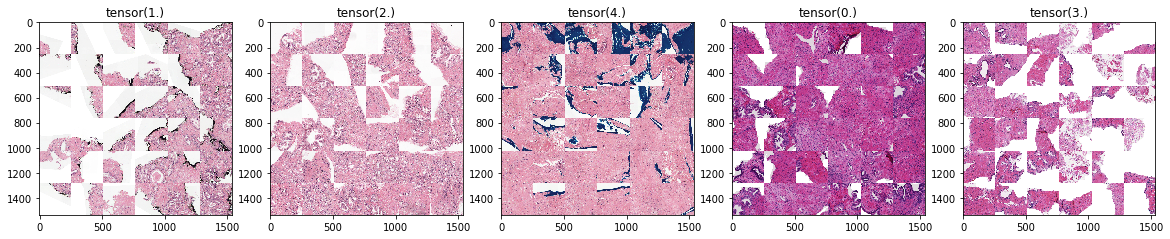

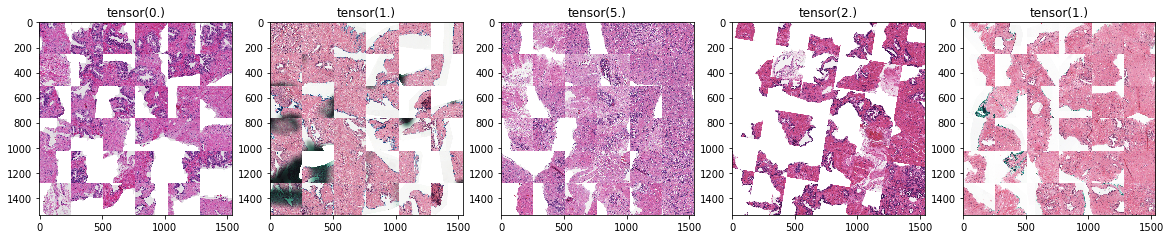

In [12]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

# Loss

In [13]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [14]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            with torch.cuda.amp.autocast():
                logits = model(data)

                loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [15]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
#scheduler_onecylce = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,n_epochs*len(train_loader))
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
print(len(dataset_train), len(dataset_valid))

8492 2124


In [16]:
model

CustomSEResNeXt(
  (model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

# Run Training

In [17]:
qwk_max = 0.
best_file = f'./ckpts/{kernel_type}_best_fold{fold}.pth'

scaler = GradScaler()

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)
    
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'./ckpts/{kernel_type}_final_fold{fold}.pth'))

Sat Jul  4 20:21:53 2020 Epoch: 1


/home/tonychenxyz/anaconda3/envs/torch1.6/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/tonychenxyz/anaconda3/envs/torch1.6/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an i


qwk 0.7706007950597978 qwk_k 0.7417211267221879 qwk_r 0.7243943946994019
Sat Jul  4 21:02:05 2020 Epoch 1, lr: 0.0000300, train loss: 0.36038, val loss: 0.30827, acc: 55.36723, qwk: 0.77060
score2 (0.000000 --> 0.770601).  Saving model ...
Sat Jul  4 21:02:06 2020 Epoch: 2



qwk 0.7883056478405316 qwk_k 0.78574348485651 qwk_r 0.7270871311201186
Sat Jul  4 21:42:19 2020 Epoch 2, lr: 0.0003000, train loss: 0.37467, val loss: 0.30667, acc: 53.38983, qwk: 0.78831
score2 (0.770601 --> 0.788306).  Saving model ...
Sat Jul  4 21:42:19 2020 Epoch: 3



qwk 0.8393677970736872 qwk_k 0.8483931514795905 qwk_r 0.7873417982755363
Sat Jul  4 22:22:29 2020 Epoch 3, lr: 0.0000300, train loss: 0.25441, val loss: 0.24942, acc: 57.58004, qwk: 0.83937
score2 (0.788306 --> 0.839368).  Saving model ...
Sat Jul  4 22:22:29 2020 Epoch: 4



qwk 0.7857770179406958 qwk_k 0.781184215106639 qwk_r 0.7266115051159701
Sat Jul  4 23:02:45 2020 Epoch 4, lr: 0.0002974, train loss: 0.31396, val loss: 0.28428, acc: 50.84746, qwk: 0.78578
Sat Jul  4 23:02:45 2020 Epoch: 5



qwk 0.8179174301378979 qwk_k 0.8112941046057683 qwk_r 0.7609586980523155
Sat Jul  4 23:43:15 2020 Epoch 5, lr: 0.0002943, train loss: 0.28964, val loss: 0.25328, acc: 56.54426, qwk: 0.81792
Sat Jul  4 23:43:15 2020 Epoch: 6



qwk 0.8237949563783987 qwk_k 0.8120243371379099 qwk_r 0.7780794222416069
Sun Jul  5 00:23:47 2020 Epoch 6, lr: 0.0002899, train loss: 0.27560, val loss: 0.26216, acc: 52.58945, qwk: 0.82379
Sun Jul  5 00:23:47 2020 Epoch: 7



qwk 0.8040569477659534 qwk_k 0.8092363169499568 qwk_r 0.7465967676375318
Sun Jul  5 01:04:14 2020 Epoch 7, lr: 0.0002843, train loss: 0.26333, val loss: 0.26934, acc: 59.13371, qwk: 0.80406
Sun Jul  5 01:04:14 2020 Epoch: 8



qwk 0.8321467554664338 qwk_k 0.8511707217578284 qwk_r 0.7711742910160996
Sun Jul  5 01:44:18 2020 Epoch 8, lr: 0.0002775, train loss: 0.25257, val loss: 0.24105, acc: 60.82863, qwk: 0.83215
Sun Jul  5 01:44:18 2020 Epoch: 9



qwk 0.8037306103738997 qwk_k 0.8352378370976031 qwk_r 0.7329293749040334
Sun Jul  5 02:24:22 2020 Epoch 9, lr: 0.0002697, train loss: 0.24524, val loss: 0.26150, acc: 59.74576, qwk: 0.80373
Sun Jul  5 02:24:22 2020 Epoch: 10



qwk 0.8394113019913404 qwk_k 0.8535859197021755 qwk_r 0.7882092640896318
Sun Jul  5 03:04:27 2020 Epoch 10, lr: 0.0002609, train loss: 0.23875, val loss: 0.25484, acc: 61.11111, qwk: 0.83941
score2 (0.839368 --> 0.839411).  Saving model ...
Sun Jul  5 03:04:27 2020 Epoch: 11



qwk 0.8370974037052532 qwk_k 0.8441820516862476 qwk_r 0.792339053815655
Sun Jul  5 03:44:32 2020 Epoch 11, lr: 0.0002511, train loss: 0.22980, val loss: 0.25864, acc: 62.19397, qwk: 0.83710
Sun Jul  5 03:44:32 2020 Epoch: 12



qwk 0.8447067629973963 qwk_k 0.8666508854433218 qwk_r 0.7876119668188324
Sun Jul  5 04:24:37 2020 Epoch 12, lr: 0.0002404, train loss: 0.22615, val loss: 0.23289, acc: 61.95857, qwk: 0.84471
score2 (0.839411 --> 0.844707).  Saving model ...
Sun Jul  5 04:24:37 2020 Epoch: 13



qwk 0.8397961401585071 qwk_k 0.8540104478513366 qwk_r 0.7816402009895902
Sun Jul  5 05:04:42 2020 Epoch 13, lr: 0.0002290, train loss: 0.22046, val loss: 0.25021, acc: 57.67420, qwk: 0.83980
Sun Jul  5 05:04:42 2020 Epoch: 14



qwk 0.8557579384796061 qwk_k 0.8698999652144581 qwk_r 0.8037893944574888
Sun Jul  5 05:44:47 2020 Epoch 14, lr: 0.0002169, train loss: 0.21119, val loss: 0.22539, acc: 61.91149, qwk: 0.85576
score2 (0.844707 --> 0.855758).  Saving model ...
Sun Jul  5 05:44:48 2020 Epoch: 15



qwk 0.8555725060681652 qwk_k 0.8757084903120139 qwk_r 0.8052841266950207
Sun Jul  5 06:24:52 2020 Epoch 15, lr: 0.0002042, train loss: 0.20490, val loss: 0.22344, acc: 64.21846, qwk: 0.85557
Sun Jul  5 06:24:52 2020 Epoch: 16



qwk 0.8488080726612837 qwk_k 0.8721125115156816 qwk_r 0.7871734628392677
Sun Jul  5 07:04:56 2020 Epoch 16, lr: 0.0001910, train loss: 0.19988, val loss: 0.25931, acc: 58.89831, qwk: 0.84881
Sun Jul  5 07:04:56 2020 Epoch: 17



qwk 0.8619751056214225 qwk_k 0.8674195627377747 qwk_r 0.8183819220762071
Sun Jul  5 07:45:01 2020 Epoch 17, lr: 0.0001776, train loss: 0.19274, val loss: 0.22152, acc: 64.50094, qwk: 0.86198
score2 (0.855758 --> 0.861975).  Saving model ...
Sun Jul  5 07:45:01 2020 Epoch: 18



qwk 0.8484733348614261 qwk_k 0.8755053465204901 qwk_r 0.7919715267077931
Sun Jul  5 08:25:05 2020 Epoch 18, lr: 0.0001638, train loss: 0.18610, val loss: 0.23520, acc: 63.88889, qwk: 0.84847
Sun Jul  5 08:25:05 2020 Epoch: 19



qwk 0.8545399173906589 qwk_k 0.8784221747250642 qwk_r 0.8023781304718202
Sun Jul  5 09:05:09 2020 Epoch 19, lr: 0.0001500, train loss: 0.18123, val loss: 0.24393, acc: 65.58380, qwk: 0.85454
Sun Jul  5 09:05:09 2020 Epoch: 20



qwk 0.8523603076162518 qwk_k 0.8572789014128495 qwk_r 0.8126552790725968
Sun Jul  5 09:45:14 2020 Epoch 20, lr: 0.0001362, train loss: 0.17028, val loss: 0.24763, acc: 64.54802, qwk: 0.85236
Sun Jul  5 09:45:14 2020 Epoch: 21



qwk 0.8691382451406199 qwk_k 0.8835688764433209 qwk_r 0.8268080541494351
Sun Jul  5 10:25:20 2020 Epoch 21, lr: 0.0001224, train loss: 0.16855, val loss: 0.24438, acc: 66.43126, qwk: 0.86914
score2 (0.861975 --> 0.869138).  Saving model ...
Sun Jul  5 10:25:20 2020 Epoch: 22



qwk 0.8576071772036917 qwk_k 0.8692526451972884 qwk_r 0.8148097519070265
Sun Jul  5 11:05:47 2020 Epoch 22, lr: 0.0001090, train loss: 0.16067, val loss: 0.24029, acc: 66.52542, qwk: 0.85761
Sun Jul  5 11:05:47 2020 Epoch: 23



qwk 0.860012979792709 qwk_k 0.8630494969441918 qwk_r 0.8259581464792911
Sun Jul  5 11:45:59 2020 Epoch 23, lr: 0.0000958, train loss: 0.15174, val loss: 0.26864, acc: 65.39548, qwk: 0.86001
Sun Jul  5 11:45:59 2020 Epoch: 24



qwk 0.8736519619151115 qwk_k 0.8890004051363786 qwk_r 0.8301327935705558
Sun Jul  5 12:26:09 2020 Epoch 24, lr: 0.0000831, train loss: 0.14720, val loss: 0.22434, acc: 65.91337, qwk: 0.87365
score2 (0.869138 --> 0.873652).  Saving model ...
Sun Jul  5 12:26:09 2020 Epoch: 25



qwk 0.8714264510706717 qwk_k 0.8906404434320718 qwk_r 0.826096786439378
Sun Jul  5 13:06:24 2020 Epoch 25, lr: 0.0000710, train loss: 0.14025, val loss: 0.25002, acc: 67.27872, qwk: 0.87143
Sun Jul  5 13:06:24 2020 Epoch: 26



qwk 0.8647684043678676 qwk_k 0.8722057727571545 qwk_r 0.8270376944183035
Sun Jul  5 13:46:59 2020 Epoch 26, lr: 0.0000596, train loss: 0.13489, val loss: 0.26328, acc: 66.52542, qwk: 0.86477
Sun Jul  5 13:46:59 2020 Epoch: 27



qwk 0.8748860751664301 qwk_k 0.88934450502751 qwk_r 0.8338486374790133
Sun Jul  5 14:27:19 2020 Epoch 27, lr: 0.0000489, train loss: 0.12660, val loss: 0.24770, acc: 67.79661, qwk: 0.87489
score2 (0.873652 --> 0.874886).  Saving model ...
Sun Jul  5 14:27:19 2020 Epoch: 28



qwk 0.8751678583836094 qwk_k 0.8885595826791437 qwk_r 0.8324788077878374
Sun Jul  5 15:07:39 2020 Epoch 28, lr: 0.0000391, train loss: 0.12483, val loss: 0.26161, acc: 66.85499, qwk: 0.87517
score2 (0.874886 --> 0.875168).  Saving model ...
Sun Jul  5 15:07:39 2020 Epoch: 29



qwk 0.8699993774175823 qwk_k 0.8847385683394914 qwk_r 0.8286634091275499
Sun Jul  5 15:47:55 2020 Epoch 29, lr: 0.0000303, train loss: 0.11820, val loss: 0.26893, acc: 67.13748, qwk: 0.87000
Sun Jul  5 15:47:55 2020 Epoch: 30



qwk 0.8693976585702702 qwk_k 0.8820001175968798 qwk_r 0.8258471224509705
Sun Jul  5 16:28:09 2020 Epoch 30, lr: 0.0000225, train loss: 0.11509, val loss: 0.26478, acc: 66.76083, qwk: 0.86940
Sun Jul  5 16:28:09 2020 Epoch: 31



qwk 0.8740921501244927 qwk_k 0.8847519502863237 qwk_r 0.8361373787116624
Sun Jul  5 17:08:36 2020 Epoch 31, lr: 0.0000157, train loss: 0.11224, val loss: 0.25917, acc: 68.07910, qwk: 0.87409
Sun Jul  5 17:08:36 2020 Epoch: 32



qwk 0.8730620137816303 qwk_k 0.8846156303211533 qwk_r 0.8338536010694041
Sun Jul  5 17:48:51 2020 Epoch 32, lr: 0.0000101, train loss: 0.10895, val loss: 0.28841, acc: 67.13748, qwk: 0.87306
Sun Jul  5 17:48:51 2020 Epoch: 33



qwk 0.8726950489352578 qwk_k 0.8855113840660884 qwk_r 0.8319849681178837
Sun Jul  5 18:29:05 2020 Epoch 33, lr: 0.0000057, train loss: 0.10815, val loss: 0.26735, acc: 66.80791, qwk: 0.87270
Sun Jul  5 18:29:05 2020 Epoch: 34



qwk 0.8752508063901658 qwk_k 0.8865471970368244 qwk_r 0.8357786710552552
Sun Jul  5 19:09:22 2020 Epoch 34, lr: 0.0000026, train loss: 0.10474, val loss: 0.26526, acc: 67.74953, qwk: 0.87525
score2 (0.875168 --> 0.875251).  Saving model ...
Sun Jul  5 19:09:22 2020 Epoch: 35



qwk 0.8722573109592734 qwk_k 0.8858017902912235 qwk_r 0.8300034600855106
Sun Jul  5 19:49:38 2020 Epoch 35, lr: 0.0000006, train loss: 0.10467, val loss: 0.27315, acc: 66.76083, qwk: 0.87226


# My Local Train Log


```
Tue June 2 15:39:21 2020 Epoch 1, lr: 0.0000300, train loss: 0.42295, val loss: 0.29257, acc: 47.50471, qwk: 0.77941
Tue June 2 15:51:56 2020 Epoch 2, lr: 0.0003000, train loss: 0.34800, val loss: 0.48723, acc: 29.09605, qwk: 0.58493
Tue June 2 16:04:28 2020 Epoch 3, lr: 0.0003000, train loss: 0.29207, val loss: 0.27091, acc: 52.49529, qwk: 0.81714
Tue June 2 16:17:01 2020 Epoch 4, lr: 0.0002965, train loss: 0.26521, val loss: 0.26736, acc: 57.15631, qwk: 0.80364
Tue June 2 16:29:33 2020 Epoch 5, lr: 0.0002921, train loss: 0.24412, val loss: 0.24422, acc: 56.07345, qwk: 0.84068
Tue June 2 16:42:05 2020 Epoch 6, lr: 0.0002861, train loss: 0.23085, val loss: 0.25306, acc: 58.05085, qwk: 0.84429
Tue June 2 16:54:38 2020 Epoch 7, lr: 0.0002785, train loss: 0.21998, val loss: 0.21920, acc: 62.14689, qwk: 0.86278
Tue June 2 17:07:10 2020 Epoch 8, lr: 0.0002694, train loss: 0.21062, val loss: 0.23400, acc: 61.91149, qwk: 0.86170
Tue June 2 17:19:47 2020 Epoch 9, lr: 0.0002589, train loss: 0.20040, val loss: 0.27417, acc: 57.10923, qwk: 0.81771
Tue June 2 17:32:25 2020 Epoch 10, lr: 0.0002471, train loss: 0.18900, val loss: 0.26732, acc: 64.92467, qwk: 0.84131
Tue June 2 17:45:05 2020 Epoch 11, lr: 0.0002342, train loss: 0.18640, val loss: 0.21936, acc: 63.27684, qwk: 0.86580
Tue June 2 17:57:42 2020 Epoch 12, lr: 0.0002203, train loss: 0.17387, val loss: 0.22863, acc: 61.25235, qwk: 0.86871
Tue June 2 18:10:23 2020 Epoch 13, lr: 0.0002055, train loss: 0.16491, val loss: 0.23071, acc: 66.85499, qwk: 0.87892
Tue June 2 18:23:00 2020 Epoch 14, lr: 0.0001901, train loss: 0.15448, val loss: 0.24338, acc: 68.45574, qwk: 0.87342
Tue June 2 18:35:39 2020 Epoch 15, lr: 0.0001743, train loss: 0.14536, val loss: 0.22043, acc: 65.11299, qwk: 0.87169
Tue June 2 18:48:18 2020 Epoch 16, lr: 0.0001581, train loss: 0.13918, val loss: 0.22007, acc: 67.65537, qwk: 0.88284
Tue June 2 19:00:55 2020 Epoch 17, lr: 0.0001419, train loss: 0.13121, val loss: 0.24287, acc: 66.71375, qwk: 0.86357
Tue June 2 19:13:35 2020 Epoch 18, lr: 0.0001257, train loss: 0.12249, val loss: 0.21583, acc: 66.80791, qwk: 0.88478
Tue June 2 19:26:14 2020 Epoch 19, lr: 0.0001099, train loss: 0.11325, val loss: 0.21401, acc: 71.13936, qwk: 0.89178
Tue June 2 19:38:55 2020 Epoch 20, lr: 0.0000945, train loss: 0.10602, val loss: 0.21250, acc: 70.00942, qwk: 0.89256
Tue June 2 19:51:32 2020 Epoch 21, lr: 0.0000797, train loss: 0.09965, val loss: 0.21149, acc: 70.33898, qwk: 0.89590
Tue June 2 20:03:59 2020 Epoch 22, lr: 0.0000658, train loss: 0.09425, val loss: 0.22203, acc: 70.76271, qwk: 0.89493
Tue June 2 20:16:28 2020 Epoch 23, lr: 0.0000529, train loss: 0.08843, val loss: 0.22948, acc: 71.70433, qwk: 0.89304
Tue June 2 20:28:56 2020 Epoch 24, lr: 0.0000411, train loss: 0.08448, val loss: 0.21200, acc: 71.18644, qwk: 0.89947
Tue June 2 20:41:25 2020 Epoch 25, lr: 0.0000306, train loss: 0.07898, val loss: 0.21873, acc: 72.55179, qwk: 0.90021
Tue June 2 20:53:53 2020 Epoch 26, lr: 0.0000215, train loss: 0.07369, val loss: 0.21842, acc: 72.64595, qwk: 0.90240
Tue June 2 21:06:20 2020 Epoch 27, lr: 0.0000139, train loss: 0.07264, val loss: 0.21501, acc: 73.21092, qwk: 0.90450
Tue June 2 21:18:49 2020 Epoch 28, lr: 0.0000079, train loss: 0.06950, val loss: 0.21616, acc: 73.35217, qwk: 0.90264
Tue June 2 21:31:16 2020 Epoch 29, lr: 0.0000035, train loss: 0.06787, val loss: 0.21195, acc: 73.11676, qwk: 0.90434
Tue June 2 21:43:43 2020 Epoch 30, lr: 0.0000009, train loss: 0.06801, val loss: 0.21014, acc: 73.11676, qwk: 0.90468
```

# Thank you for reading!